# Project 3: Web APIs & NLP

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
# Set viewing options
pd.set_option('display.max_columns', 10000)

## Data Cleaning (flights)

In [3]:
#reload the data csv file
df_flights = pd.read_csv('../data/flights_subs.csv')
df_hotels = pd.read_csv('../data/hotels_subs.csv')

In [4]:
df_flights.head(10)

,subreddit,selftext,title,created_utc
0,Flights,"To date, I just purchased my cheapest internat...",$9AUD Flight,1678772376
1,Flights,NaN,I'm an engineer with a design to reverse engin...,1678761426
2,Flights,[removed],TAP AIR FLIGHT SONG,1678756695
3,Flights,Context: I got a flight centre gift card for $...,what would you do? awful rule regarding Porter...,1678753898
4,Flights,[removed],EVA Air CC Verification,1678749479
5,Flights,"So I learned, don’t book through credit card t...",Booked through capital one,1678749255
6,Flights,Currently looking at flights from Europe to Ta...,EVA Air 777-300 or 787-9?,1678742265
7,Flights,[removed],Charged twice for the same piece of checked lu...,1678739090
8,Flights,[removed]\n\n[View Poll](https://www.reddit.co...,Virgin Atlantic vs. Turkish from LHR to Texas?,1678735250
9,Flights,I’m flying from New Dehli to London with a lay...,Etihad Airways allow earlier flights?,1678732821


In [5]:
df_flights.isnull().sum()

subreddit        0
selftext       937
title            0
created_utc      0
dtype: int64

In [6]:
#Detect & remove empty strings
#Technically, we're dealing with "whitespace only" strings.

#In order to detect these strings we need to iterate over each row in the DataFrame. The .itertuples() pandas method is a good tool for this as it provides access to every field. For brevity we'll assign the names i, lb and rv to the index, label and review columns.

blanks = []  # start with an empty list

for index, subreddut, selftext, title, created in df_flights.itertuples():  # iterate over the DataFrame
    if type(title)==str:            # avoid NaN values
        if title.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)
blanks = []  # start with an empty list

0 blanks:  []


reference: Since there is no whitespace in title, we change change the null in selftext to space so that we can later combine the column title and self text

In [7]:
# Define a function to replace null values with '-'
def replace_nulls(data, col_list):
    for col in col_list:
        data.loc[data[col].isnull(), col] = '-'
    return data

In [8]:
# Replace nulls with '-'
df_flights = replace_nulls(df_flights, ['selftext'])

# Check that changes stuck
df_flights.isnull().sum()

subreddit      0
selftext       0
title          0
created_utc    0
dtype: int64

In [9]:
#noticed many '[removed]' in selftext, count them to be exact
count_removed = (df_flights['selftext'] == '[removed]').sum()
print(f"Number of rows where 'selftext' is '[removed]': {count_removed}")

Number of rows where 'selftext' is '[removed]': 991


In [10]:
#we should change the removed to space as we will combine the title and self text together for the classification model thus no need to remove null
df_flights['selftext'] = df_flights['selftext'].replace('[removed]', '')

In [11]:
df_flights.duplicated().sum() #ensure no duplicate columns

0

In [12]:
# combine the 'selftext' and 'title' columns into a new column 'text'
df_flights['text'] = df_flights['title'] + ' ' + df_flights['selftext']

In [13]:
df_flights.head()

,subreddit,selftext,title,created_utc,text
0,Flights,"To date, I just purchased my cheapest internat...",$9AUD Flight,1678772376,"$9AUD Flight To date, I just purchased my chea..."
1,Flights,-,I'm an engineer with a design to reverse engin...,1678761426,I'm an engineer with a design to reverse engin...
2,Flights,,TAP AIR FLIGHT SONG,1678756695,TAP AIR FLIGHT SONG
3,Flights,Context: I got a flight centre gift card for $...,what would you do? awful rule regarding Porter...,1678753898,what would you do? awful rule regarding Porter...
4,Flights,,EVA Air CC Verification,1678749479,EVA Air CC Verification


In [14]:
# drop the 'selftext' and 'title' columns from the dataframe
df_flights = df_flights.drop(['title', 'selftext'], axis=1)

In [15]:
df_flights.head()

,subreddit,created_utc,text
0,Flights,1678772376,"$9AUD Flight To date, I just purchased my chea..."
1,Flights,1678761426,I'm an engineer with a design to reverse engin...
2,Flights,1678756695,TAP AIR FLIGHT SONG
3,Flights,1678753898,what would you do? awful rule regarding Porter...
4,Flights,1678749479,EVA Air CC Verification


In [16]:
df_flights.shape

(4996, 3)

In [17]:
df_flights['created_utc'] = pd.to_datetime(df_flights['created_utc'], unit='s')

In [18]:
df_flights['created_utc'] = df_flights['created_utc'].dt.date
df_flights = df_flights.rename(columns={'created_utc': 'date'})

In [19]:
df_flights.tail()

,subreddit,date,text
4991,Flights,2017-04-02,Do children need ID to travel domestically? I ...
4992,Flights,2017-04-02,UÇUŞ RÖTARINDA TAZMİNAT ALMAK -
4993,Flights,2017-04-01,"Help figuring out a flight to Bulgaria Hi, jus..."
4994,Flights,2017-04-01,Is this a bait and switch by Southwest? [deleted]
4995,Flights,2017-03-31,"Flying to Rome, transferring flight in London...."


## Data Cleaning (hotels)

In [20]:
df_hotels.head(10)

,subreddit,selftext,title,created_utc
0,hotels,I made a huge mistake booking a hotel for an u...,Double booking + egregious hotel cancellation ...,1678763009
1,hotels,Hello All! \nI am currently applying for assis...,Hotel Managment,1678760121
2,hotels,[removed],Parking pass,1678759326
3,hotels,[removed],A Journey Through The Oceana Hotel Culinary Wo...,1678731744
4,hotels,[removed],Chime Card at Las Vegas Hotels,1678730632
5,hotels,[removed],HOTEL INFANTE SAGRES: LUXURIOUS HISTORY IN OPORTO,1678727673
6,hotels,[removed],Which hotels let you check in online and selec...,1678720216
7,hotels,[removed],Which hotel lets you check in online and selec...,1678720154
8,hotels,[removed],Streamline Your Vacation Rental Business with ...,1678693233
9,hotels,I prepaid for a room at a hotel in Texas about...,Charged extra due to tax rate increase,1678665538


In [21]:
df_hotels.isnull().sum()

subreddit         0
selftext       2464
title             0
created_utc       0
dtype: int64

In [22]:
#Detect & remove empty strings
#Technically, we're dealing with "whitespace only" strings.

#In order to detect these strings we need to iterate over each row in the DataFrame. The .itertuples() pandas method is a good tool for this as it provides access to every field. For brevity we'll assign the names i, lb and rv to the index, label and review columns.

blanks = []  # start with an empty list

for index, subreddut, selftext, title, created in df_hotels.itertuples():  # iterate over the DataFrame
    if type(title)==str:            # avoid NaN values
        if title.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)
blanks = []  # start with an empty list

0 blanks:  []


reference: Since there is no whitespace in title, we change change the null in selftext to space so that we can later combine the column title and self text

In [23]:
# Replace nulls with '-'
df_hotels = replace_nulls(df_hotels, ['selftext'])

# Check that changes stuck
df_hotels.isnull().sum()

subreddit      0
selftext       0
title          0
created_utc    0
dtype: int64

In [24]:
#noticed many '[removed]' in selftext, count them to be exact
count_removed = (df_hotels['selftext'] == '[removed]').sum()
print(f"Number of rows where 'selftext' is '[removed]': {count_removed}")

Number of rows where 'selftext' is '[removed]': 2044


In [25]:
#we should change the removed to space as we will combine the title and self text together for the classification model thus no need to remove null
df_hotels['selftext'] = df_hotels['selftext'].replace('[removed]', '')

In [26]:
# combine the 'selftext' and 'title' columns into a new column 'text'
df_hotels['text'] = df_hotels['title'] + ' ' + df_hotels['selftext']

In [27]:
# drop the 'selftext' and 'title' columns from the dataframe
df_hotels = df_hotels.drop(['title', 'selftext'], axis=1)

In [28]:
df_hotels.tail()

,subreddit,created_utc,text
4995,hotels,1408427884,GruppenreisenUK -
4996,hotels,1408426969,Choose Family Hotels in Dubai for a Lovely Vac...
4997,hotels,1408426560,Five must-see European castles -
4998,hotels,1408425765,Five must-see European castles -
4999,hotels,1408392966,"Doubletree Hotel in Port Huron, Michigan -"


In [29]:
df_hotels.shape

(5000, 3)

In [30]:
df_hotels['created_utc'] = pd.to_datetime(df_hotels['created_utc'], unit='s')

In [31]:
df_hotels['created_utc'] = df_hotels['created_utc'].dt.date
df_hotels = df_hotels.rename(columns={'created_utc': 'date'})

In [32]:
df_hotels.tail()

,subreddit,date,text
4995,hotels,2014-08-19,GruppenreisenUK -
4996,hotels,2014-08-19,Choose Family Hotels in Dubai for a Lovely Vac...
4997,hotels,2014-08-19,Five must-see European castles -
4998,hotels,2014-08-19,Five must-see European castles -
4999,hotels,2014-08-18,"Doubletree Hotel in Port Huron, Michigan -"


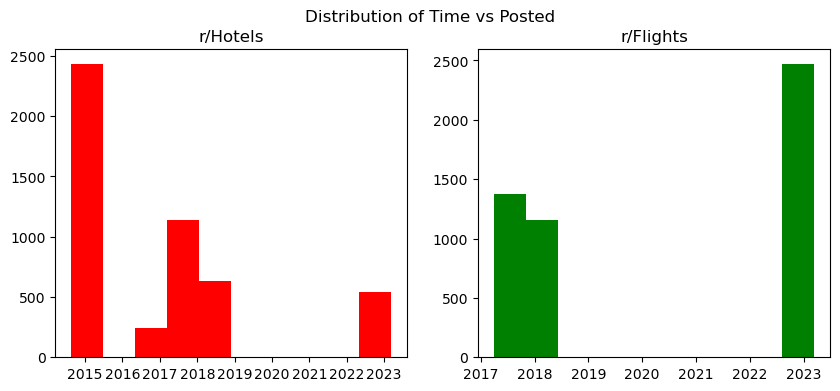

In [33]:
#Plotting distribution of time posted
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(df_hotels['date'], color='red')
ax1.set_title('r/Hotels')


ax2.hist(df_flights['date'], color='green')
ax2.set_title('r/Flights')

fig.suptitle('Distribution of Time vs Posted')

plt.show()

reference: it seems that r/flights have more recent posting compared to hotels, there is this possibility as previously Covid not many travel on flight and also flights seats are very restricted as well whereas hotels still open for staycations so there are more post in between in general. 

### Remove duplicate

In [34]:
# drop the 'date' columns from the dataframe as not requested in the classification model
df_hotels = df_hotels.drop(['date'], axis=1)
df_flights = df_flights.drop(['date'], axis=1)

In [35]:
df_hotels.duplicated().sum() #ensure no duplicate columns

233

In [36]:
df_hotels = df_hotels.drop_duplicates()
df_hotels.duplicated().sum()

0

In [37]:
df_flights.duplicated().sum() #ensure no duplicate columns

37

In [38]:
df_flights = df_flights.drop_duplicates()
df_flights.duplicated().sum()

0

## Saved Clean Datasets

In [42]:
#Data is clean, here is what we will like to save it as
#index = false for no index column
df_hotels = df_hotels.to_csv('../data/hotels_cleaned.csv', index = False)
df_flights = df_flights.to_csv('../data/flights_cleaned.csv', index = False)

## Continue to Notebook 3: Pre-Processing